## Fully Quantum Model
The main model that uses Haar measure for the forward process and quantum layers for denoising.

In [ ]:
from utils.statistics import calculate_statistics, calculate_fid
from utils.decoding import decode, flip


### Data Preparation using the partially preprocessed files

In [1]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [3]:
QG_channel = 1
filename = f"data/QG{QG_channel}_normalized_16x16_100k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 1000

encoded_data_load = torch.load(f"data/Q{QG_channel}_16x16_100k_encoded.pt")
print(encoded_data_load.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data_load), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

C:\Users\realc\AppData\Local\Temp\ipykernel_18852\1570002199.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_data_load = torch.load(f"data/Q{QG_channel}_16x16_10

torch.Size([100000, 8, 8, 4])


KeyboardInterrupt: 

In [ ]:
'''Testing with non normalized or discretized images'''
QG_channel = 1
filename = f"data/QG{QG_channel}_16x16_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

num_samples = 100

encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

KeyboardInterrupt: 

### Create the fully quantum model

In [4]:
encoded_data = encoded_data_load

train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.n_qubits = n_qubits
        self.num_patches = input_dim // n_qubits
        
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        
    def forward(self, x):
        x_patched = x.view(-1, self.num_patches, self.n_qubits)  # [batch_size, num_patches, n_qubits]

        output_patches = []
        for patch in range(self.num_patches):
            patch_out = self.quantum_layer(x_patched[:, patch])
            output_patches.append(patch_out)
        
        x = torch.cat(output_patches, dim=1)
        
        return x

In [5]:
n_layers = 8
input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))

plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Epoch [1/100], Loss: 0.9550, Val Loss: 0.9232
Epoch [2/100], Loss: 0.9239, Val Loss: 0.8932
Epoch [3/100], Loss: 0.8940, Val Loss: 0.8647
Epoch [4/100], Loss: 0.8655, Val Loss: 0.8379
Epoch [5/100], Loss: 0.8387, Val Loss: 0.8131


KeyboardInterrupt: 

In [14]:
saved_model_path = f"fq_{num_epochs}e_{num_samples}s_{n_qubits}q_{n_layers}l"
torch.save(model.state_dict(), saved_model_path)

### Post-training model loading, analysis, and plotting

In [2]:
model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
model.load_state_dict(torch.load(saved_model_path, weights_only=True))
model.eval()

NameError: name 'QuantumDiffusionModel' is not defined

In [7]:
num_samples_to_generate = 10
new_images = generate_new_images(model, num_samples_to_generate)
plot_all_decoded_images(new_images)
# plot_mean_decoded_images(new_images)
# plot_all_decoded_images(new_images, grid_size=(10, 10))

In [8]:
generated_data = new_images

real_data = data_X[:len(generated_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(flip(generated_data))
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

wasserstein_value = calculate_wasserstein(real_data, flip(generated_data))
print("Wasserstein 1 ", wasserstein_value)

FID  4.869327708386491
Wasserstein 1  0.10147035343106836


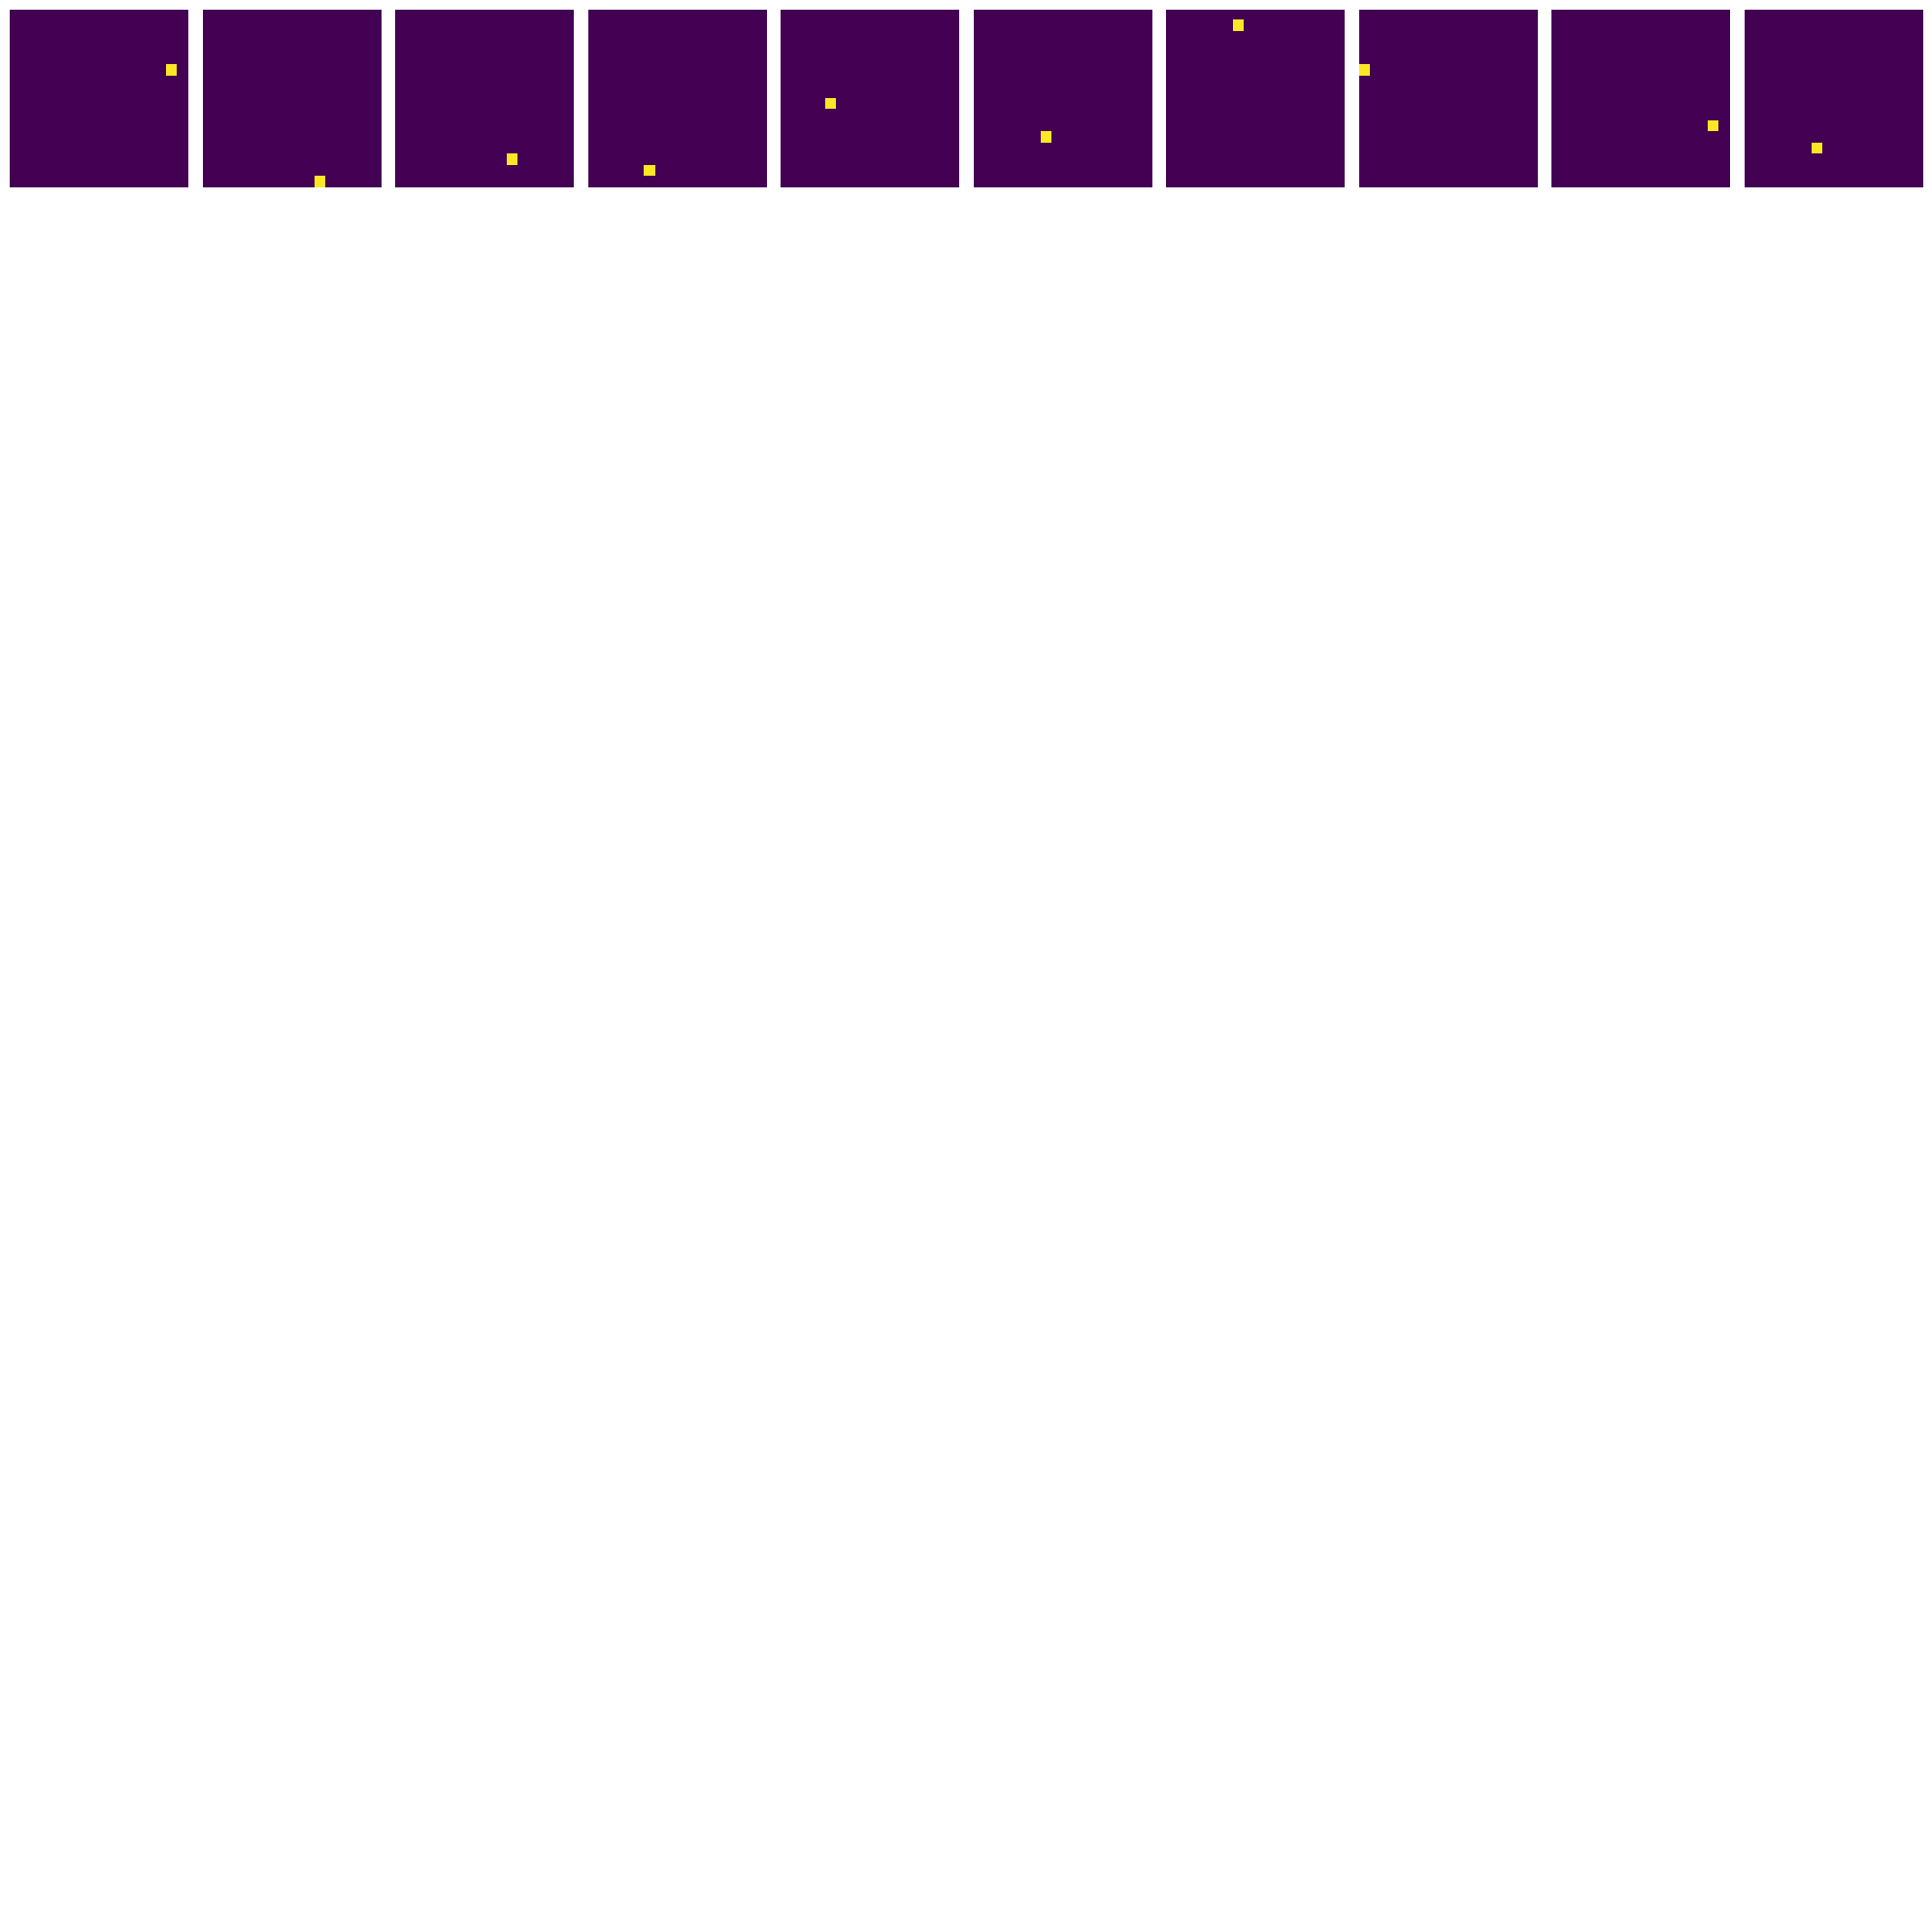

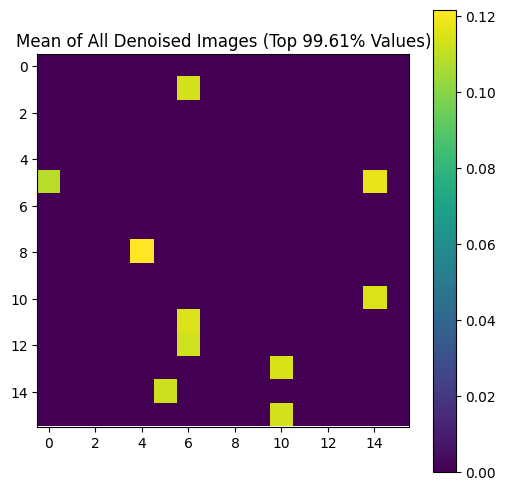

FID  2.541497484982296
Stable FID: 2.5288168323027533
Wasserstein 1  0.0021295232232660054


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


In [9]:
denoised_images = plot_decoded_images_without_noise(new_images, grid_size=(10, 10), threshold_percent=99.61)

limit = 10
real_data = real_data[:limit]
denoised_images = denoised_images[:limit]
mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(denoised_images)
fid = calculate_fid_stable(mu_real, sigma_real, mu_gen, sigma_gen)
print("Stable FID:", fid)

wasserstein_value = calculate_wasserstein(real_data, denoised_images)
print("Wasserstein 1 ", wasserstein_value)

In [17]:
sign = "1"
exponent = "10000011"
mantissa = "00100111010001001000101"
exponent = int(exponent, 2) - 127 # compensate for bias
mantissa = 1.0 + int(mantissa, 2) / 2 ** len(mantissa) # convert to 1.xxxx format
print("exponent (decimal, including bias)", exponent)
print("mantissa (decimal, including leading 1)", mantissa)
if sign == "1":
    number = -1 * mantissa * 2 ** exponent
else:
    number = mantissa * 2 ** exponent
print("number", number)

exponent (decimal, including bias) 4
mantissa (decimal, including leading 1) 1.153389573097229
number -18.454233169555664
